In [33]:
import pandas as pd
import shap
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [34]:
train_data = pd.read_csv('../twitter_fsa/data/train_cleaned.csv')

In [35]:
trained_model = AutoModelForSequenceClassification.from_pretrained("best_model/distill_bert_layer_4/fine_tune_1/model")
trained_model.eval()
saved_tokenizer = AutoTokenizer.from_pretrained("best_model/distill_bert_layer_4/fine_tune_1/components/tokenizer")


In [38]:
import torch
from torch.nn.functional import cross_entropy

def get_loss(batch):
    inputs = {k:torch.tensor(v) for k,v in batch.items()
              if k in saved_tokenizer.model_input_names}

    with torch.no_grad():
        output = trained_model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, torch.tensor(batch["label"]), reduction="none")
    return {"loss": loss,
            "predicted_label": pred_label}

In [40]:
from datasets import load_dataset

val_dataset = load_dataset("csv",data_files="data/validation_cleaned.csv")["train"]
val_tokenized = val_dataset.map(
    lambda batch: saved_tokenizer(
        batch["text"], padding=True
    ),batched=True, batch_size=64)
loss_dataset = val_tokenized.map(
    get_loss, batched=True, batch_size=64)

loss_dataset.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
loss_df = loss_dataset[:][cols]
loss_df.head()

,text,label,predicted_label,loss
0,New Zealand s resurgent housing market could g...,2,1,2.411012
1,Gold Soars To 8 Year Highs As Stocks Melt Up O...,1,1,0.047286
2,Biotage AB reports Q4 results,2,2,0.011861
3,Has Disney s Star Wars Acquisition Been a Fa...,2,2,0.016810
4,STOCK Urban Outfitters stands out in mall se...,1,1,0.323574


In [47]:
sorted_loss_df = loss_df.sort_values("loss", ascending=False)
sorted_loss_df.head()

,text,label,predicted_label,loss
1792,5 Reasons To Love Wendy s On Its 50th Birthday,1,2,6.610523
545,Congratulations to Phreesia NYSE STOCK who ...,1,2,6.063853
1716,STOCK Ally Financial pulls outlook HTTPS_URL,0,2,6.006780
1751,Every Bubble Eventually Finds Its Pin HTTPS_URL,0,2,5.474049
82,NVIDIA GPU Powered Semi Simulation Snags Cov...,1,2,5.274352


In [48]:
bearish_bullish = sorted_loss_df[(sorted_loss_df["label"] == 0) & (sorted_loss_df["predicted_label"] == 1)]
bearish_bullish

,text,label,predicted_label,loss
1009,Analysts Eviscerate Musk s Cybertruck 0 Of ...,0,1,4.215179
1418,Spanish Farmers Rise Up Against Unfair Prices ...,0,1,4.109963
1323,Dow heavyweight Boeing ending strong decade wi...,0,1,3.779691
1484,Hedge Funds Aren t Crazy About Titan Machinery...,0,1,3.766412
684,Hedge Funds Aren t Crazy About eGain Communica...,0,1,3.538390
185,Trans Mountain Costs to Increase 70 to $9.5 B...,0,1,3.533501
1353,Tesla 3 as China slowdown factors in,0,1,3.246937
1641,STOCK 1.8 pre Chimera Investment CIM Ann...,0,1,3.055100
1324,Jobless claims hits 2.5 months high,0,1,2.934105
254,Bank of America sees demand surge for paycheck...,0,1,2.787041


In [49]:
pred = transformers.pipeline(
    "text-classification",
    model=trained_model,
    tokenizer=saved_tokenizer,
    top_k=None
)
explainer = shap.Explainer(pred)


Device set to use cuda:0


In [50]:
shap_values = explainer(bearish_bullish["text"][:3])

In [53]:
shap.plots.text(shap_values)

In [52]:
shap.plots.text(shap_values[:,:,"LABEL_1"])

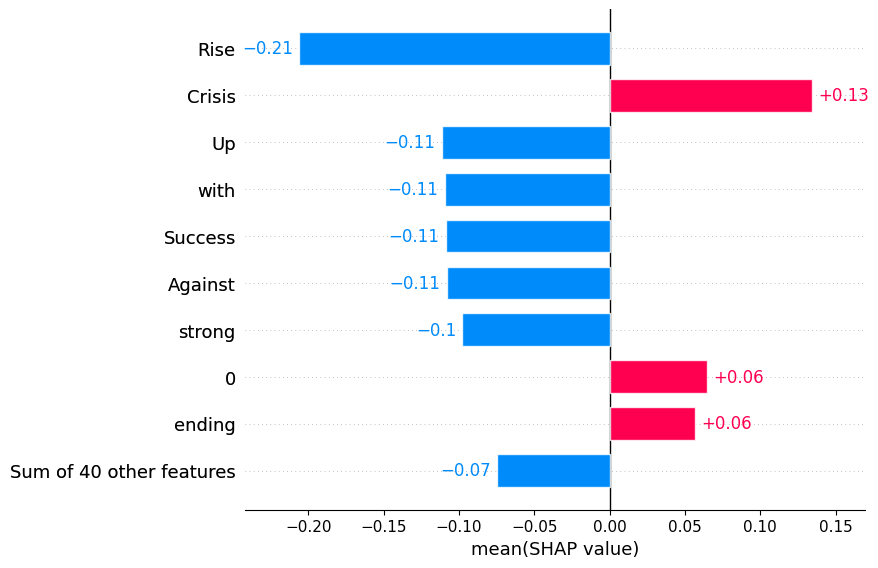

In [54]:
shap.plots.bar(shap_values[:, :, "LABEL_0"].mean(0))

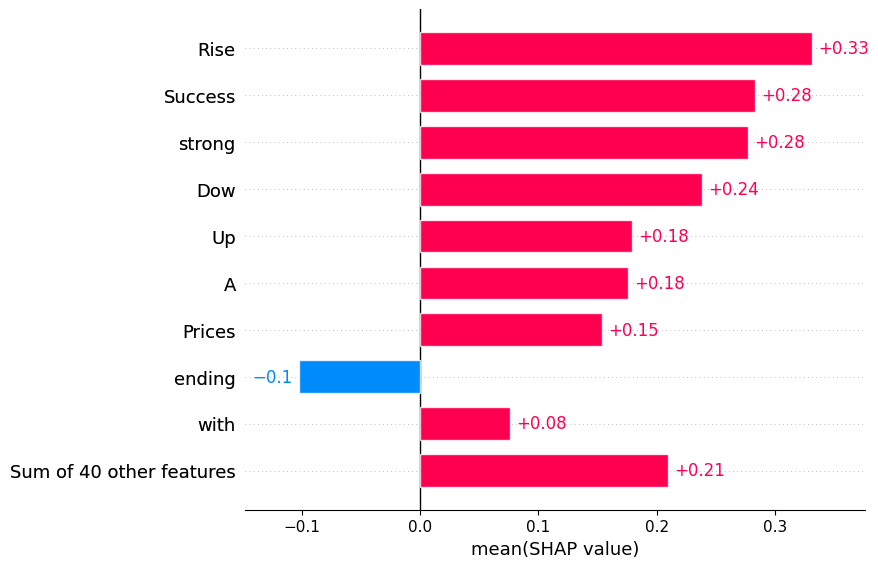

In [55]:
shap.plots.bar(shap_values[:, :, "LABEL_1"].mean(0))

In [56]:
samples = ["Stock prices rise up after earnings." , "Farmers rise up against prices."]
samples_shap_values = explainer(samples)

In [57]:
shap.plots.text(samples_shap_values)

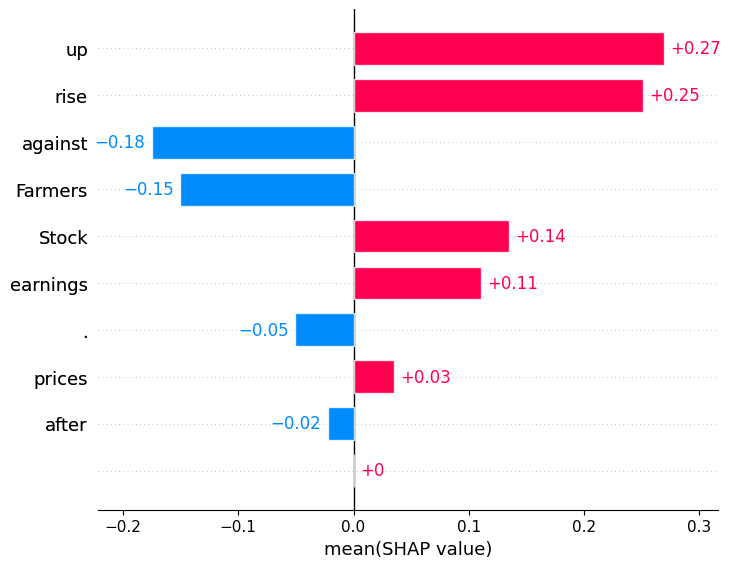

In [58]:
shap.plots.bar(samples_shap_values[:, :, "LABEL_1"].mean(0))

In [59]:
bullish_bearish = sorted_loss_df[(sorted_loss_df["label"] == 1) & (sorted_loss_df["predicted_label"] == 0)]
bullish_bearish

,text,label,predicted_label,loss
1112,Stock Traders Are Dumping Virus Hedges After ...,1,0,4.720994
1453,Weekly portfolios report Stress quickly eras...,1,0,4.346392
882,Samsung first quarter beats estimates chips l...,1,0,4.142551
130,STOCK STOCK Gold Silver Update December M...,1,0,3.816262
174,Wall Street scraps its recession assumptions a...,1,0,3.761425
664,"S P 500, Nasdaq see closing highs Slack halte...",1,0,3.717592
1257,Tech stocks led all three major U.S. stock ave...,1,0,3.386596
1126,Hong Kong Stocks Nearly Recover Post Holiday L...,1,0,3.229310
1234,Highlight Edward Jones Sr. Equity Analyst Jen...,1,0,3.088754
1247,RECAP 12 10 Pos Comments \nSTOCK Hedgeye\nS...,1,0,2.916244
